In [ ]:
!pip install -U layoutparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-z9urdgip/detectron2_cb38271e66454cbbb1475e21dbf5c6d2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-z9urdgip/detectron2_cb38271e66454cbbb1475e21dbf5c6d2
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install layoutparser[ocr]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/Layout-Parser/layout-parser.git

fatal: destination path 'layout-parser' already exists and is not an empty directory.


In [ ]:
%cd layout-parser/

/content/layout-parser


In [ ]:
!apt-get install poppler-utils
!pip install pdf2image
from pdf2image import convert_from_path
#imports the convert_from_path function from the pdf2image library.
#convert PDF pages into PIL (Python Imaging Library) images.
from google.colab.patches import cv2_imshow

from PIL import Image
import numpy as np
import cv2
import layoutparser as lp

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.86.1-0ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pdf_path = "/content/beko_removed.pdf"
images = convert_from_path(pdf_path)

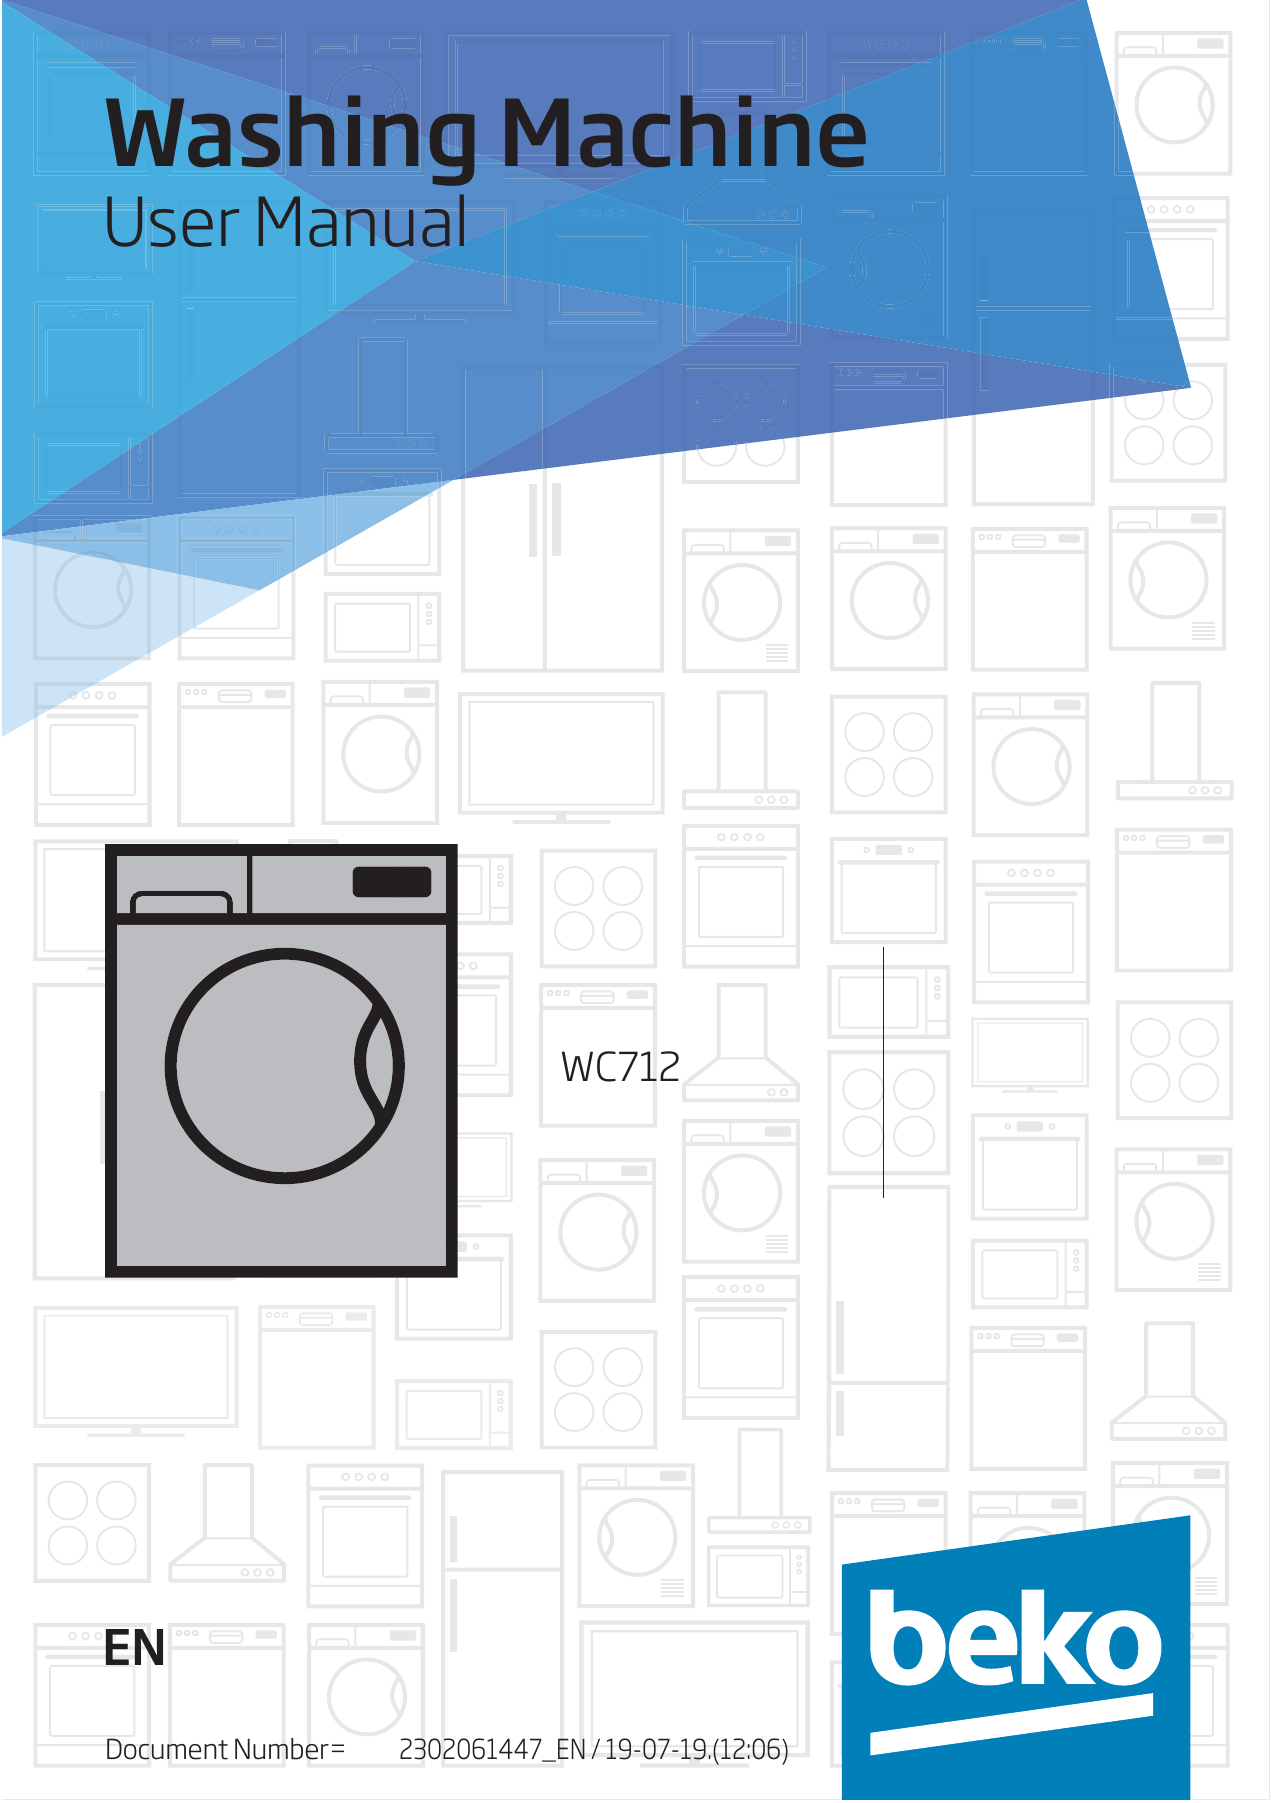

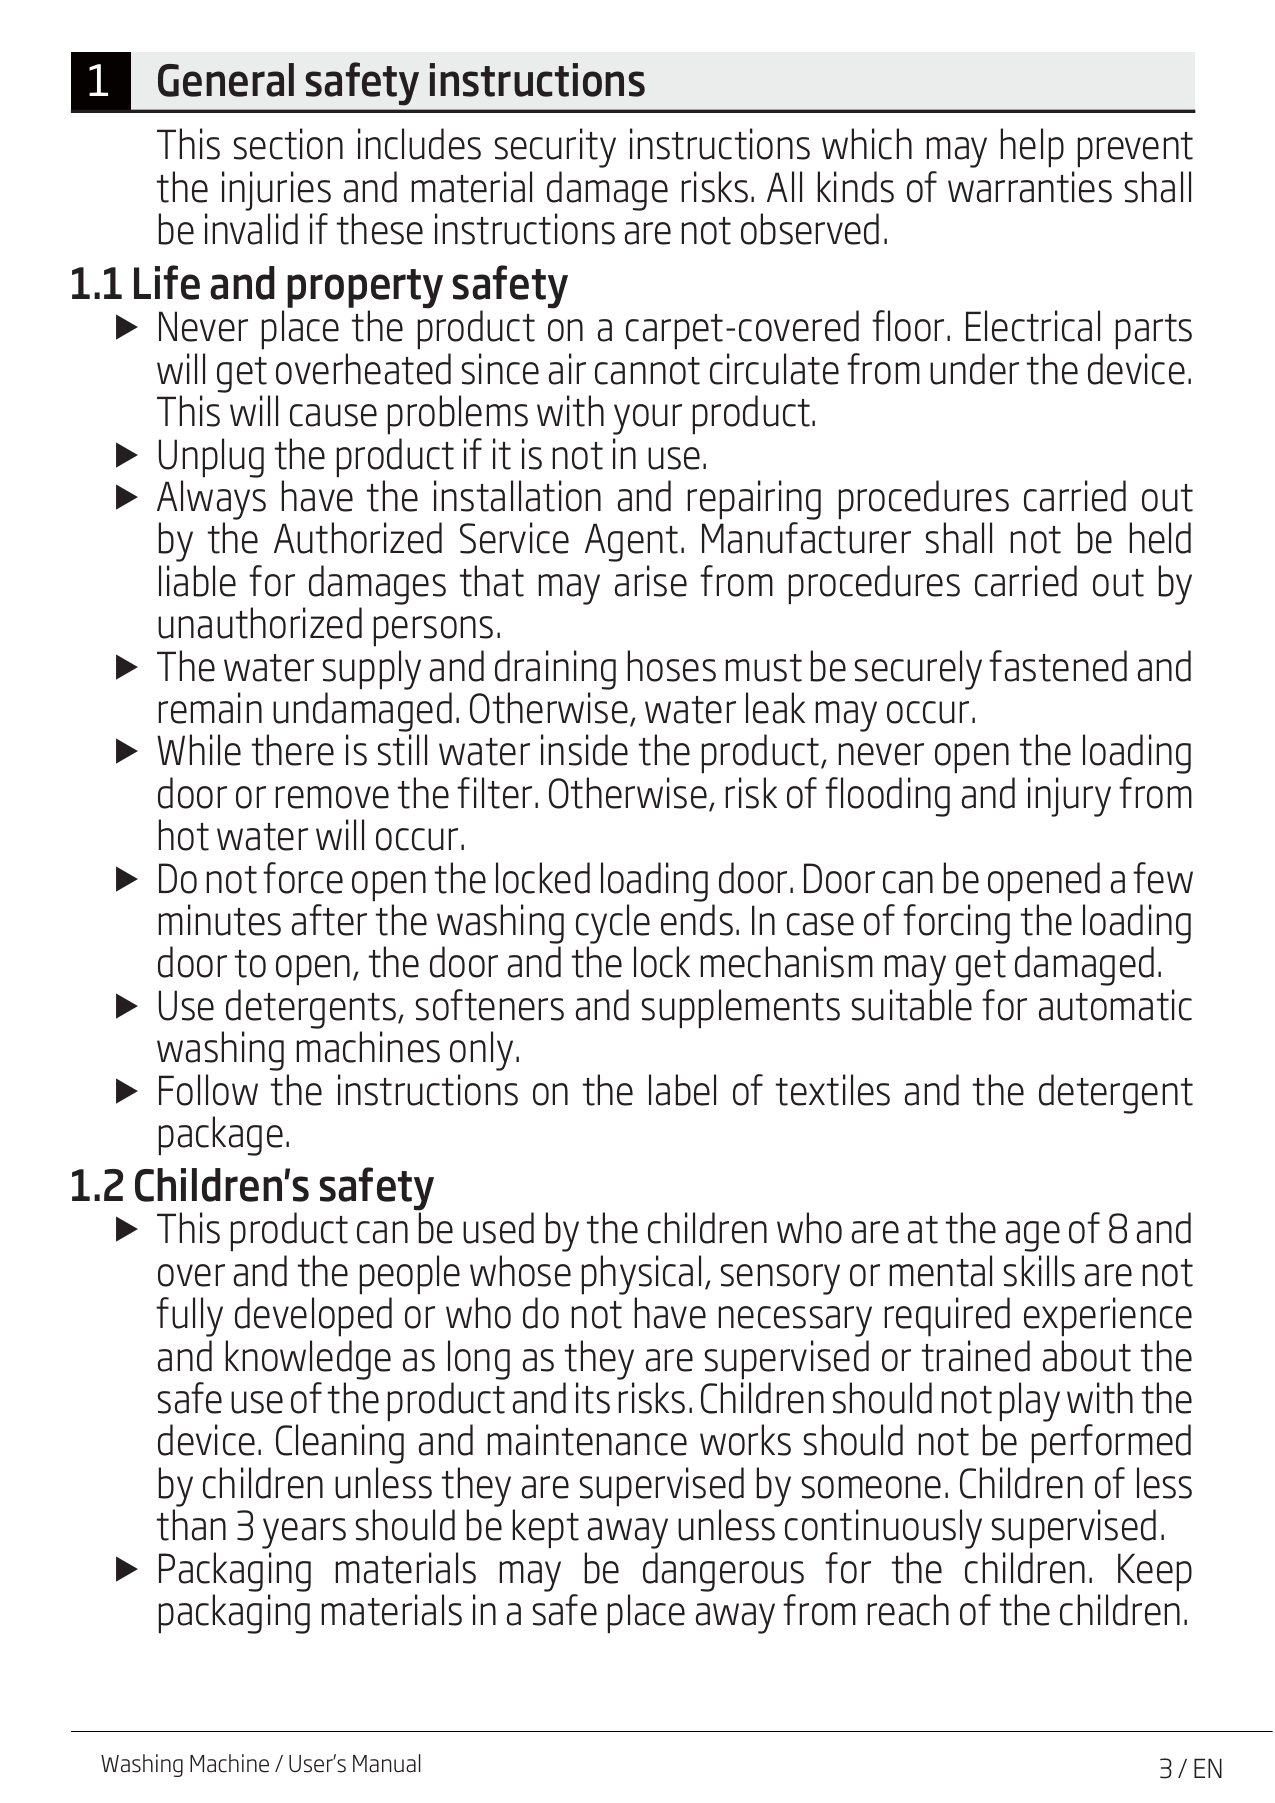

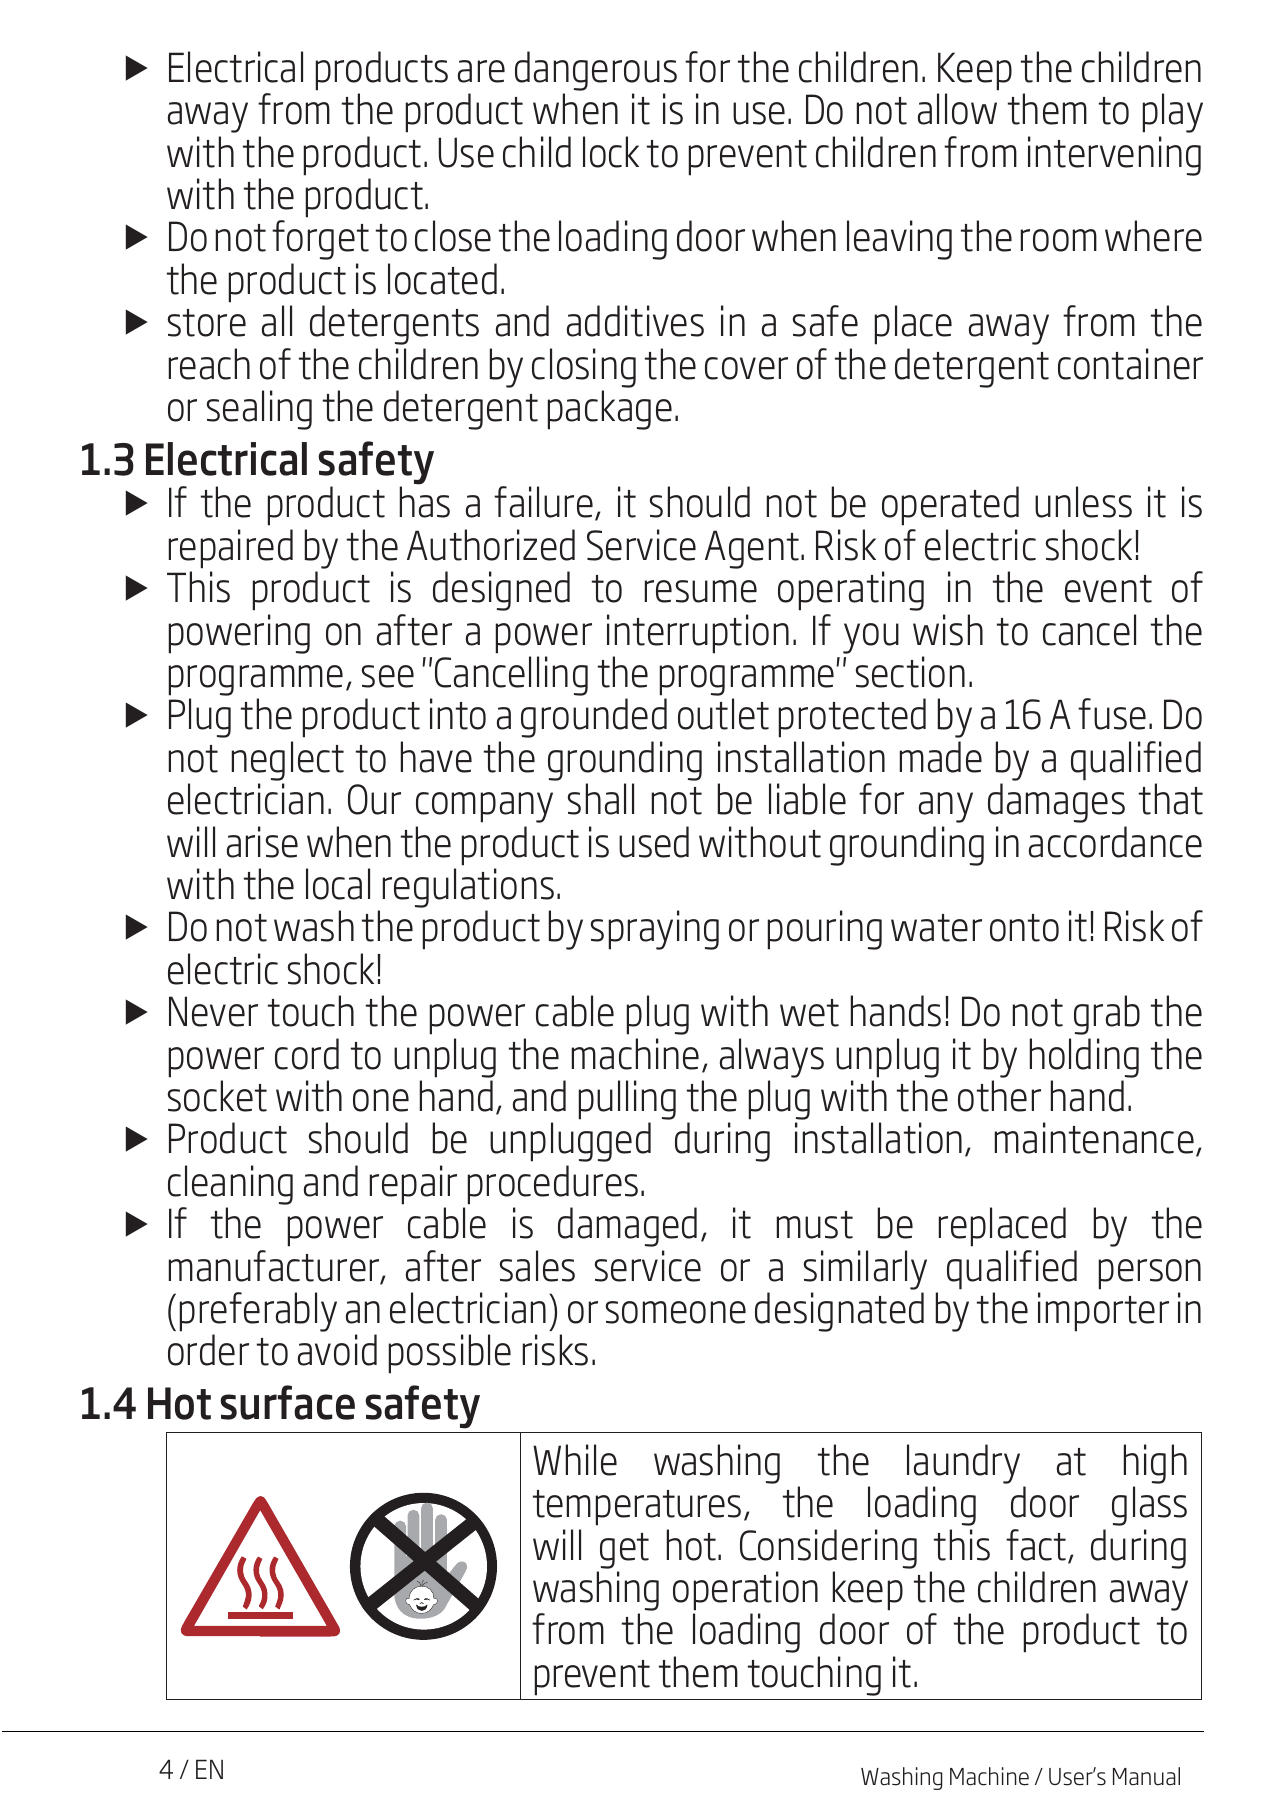

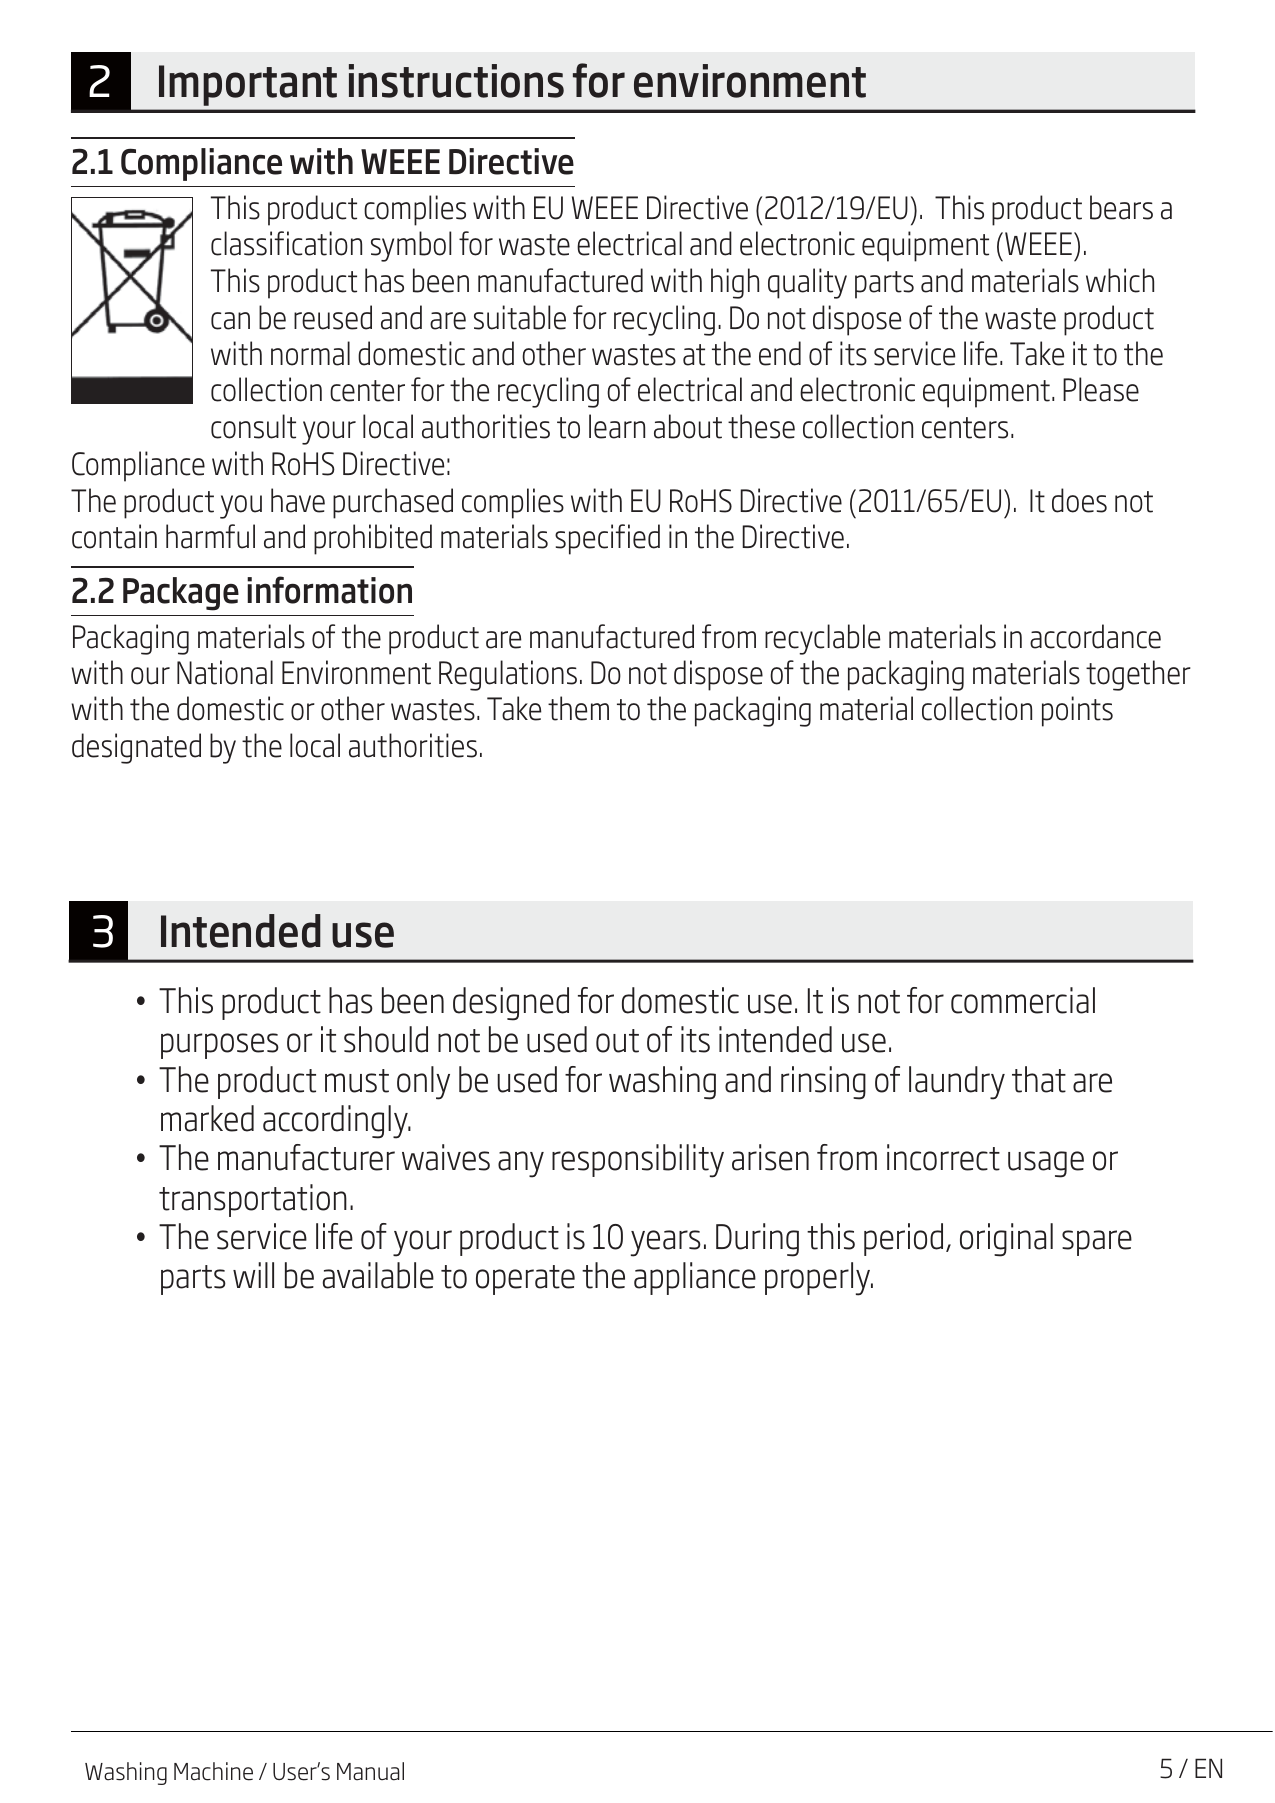

In [ ]:
import cv2

for image in images:
    # Convert PIL image to OpenCV format
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Perform any required image processing operations
    # ...

    # Display or save the processed image
    cv2_imshow(image_cv)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


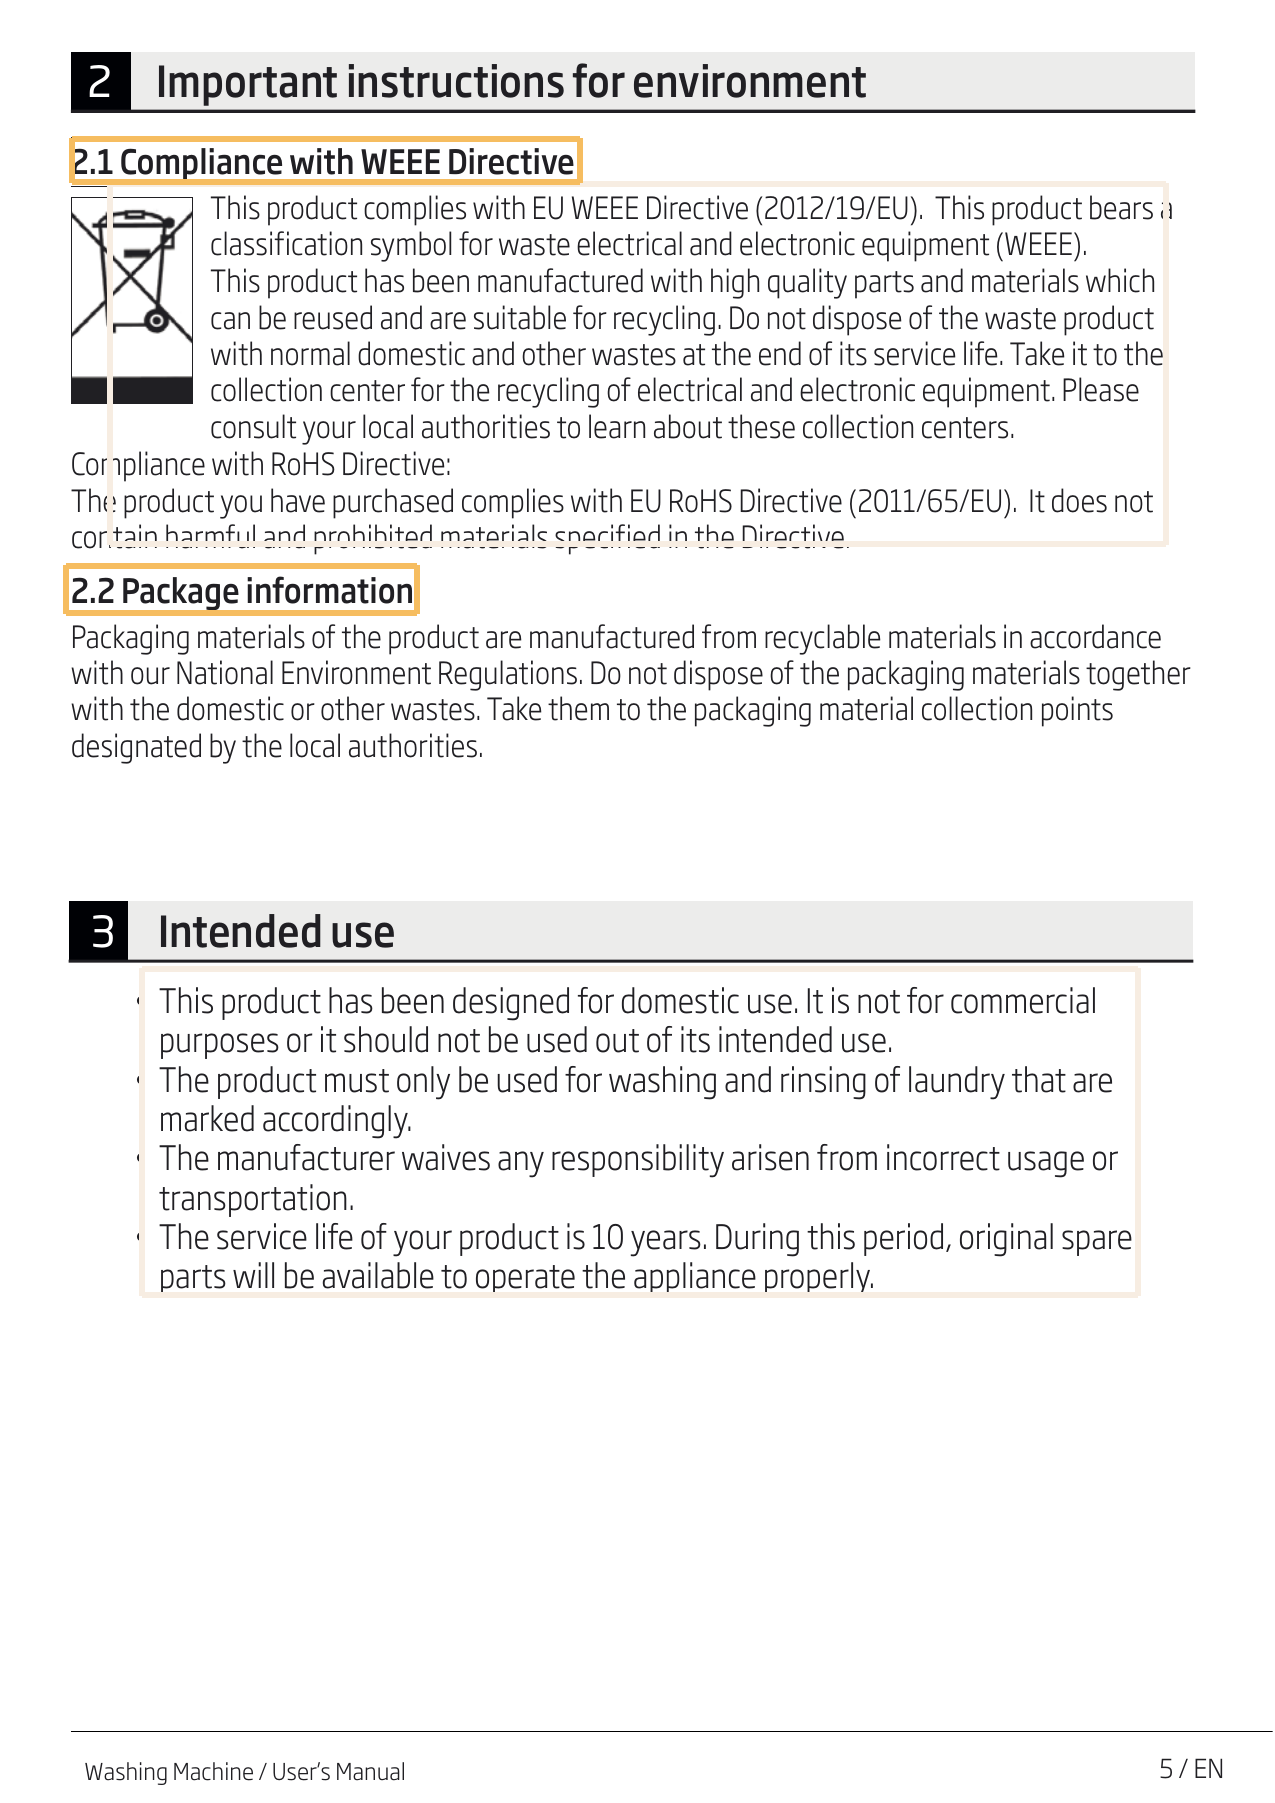

In [ ]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image_cv) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image_cv, layout,)

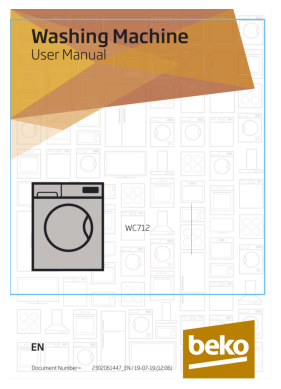

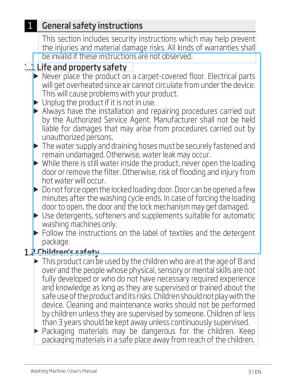

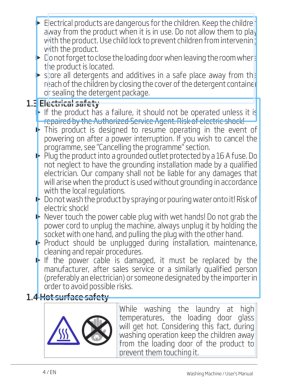

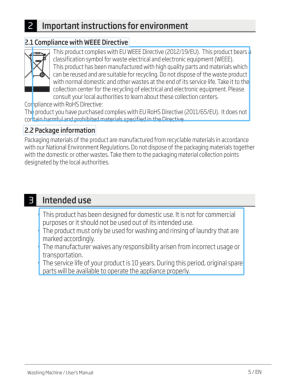

In [ ]:
import layoutparser as lp
import cv2
import matplotlib.pyplot as plt
import numpy as np

model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

# we have a list of images named `images` obtained from PDF conversion
for image_cv in images:
    layout = model.detect(image_cv)
    image_with_boxes = lp.draw_box(image_cv, layout)

    # Convert PIL Image to NumPy array
    image_np = np.array(image_with_boxes)

    # Display the image with layout boxes
    plt.imshow(image_np[:,:,::-1])  # Convert BGR to RGB
    plt.axis('off')
    plt.show()


In [ ]:
text_blocks = lp.Layout([b for b in layout if b.type=="Title"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=66.15438842773438, y_1=565.149169921875, x_2=416.25152587890625, y_2=613.8631591796875), text=None, id=None, type=Title, parent=None, next=None, score=0.9465169906616211), TextBlock(block=Rectangle(x_1=72.63218688964844, y_1=138.83639526367188, x_2=579.7384033203125, y_2=182.8091583251953), text=None, id=None, type=Title, parent=None, next=None, score=0.7479046583175659)], page_data={})

In [ ]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [ ]:
h, w = image_cv.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image_cv)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

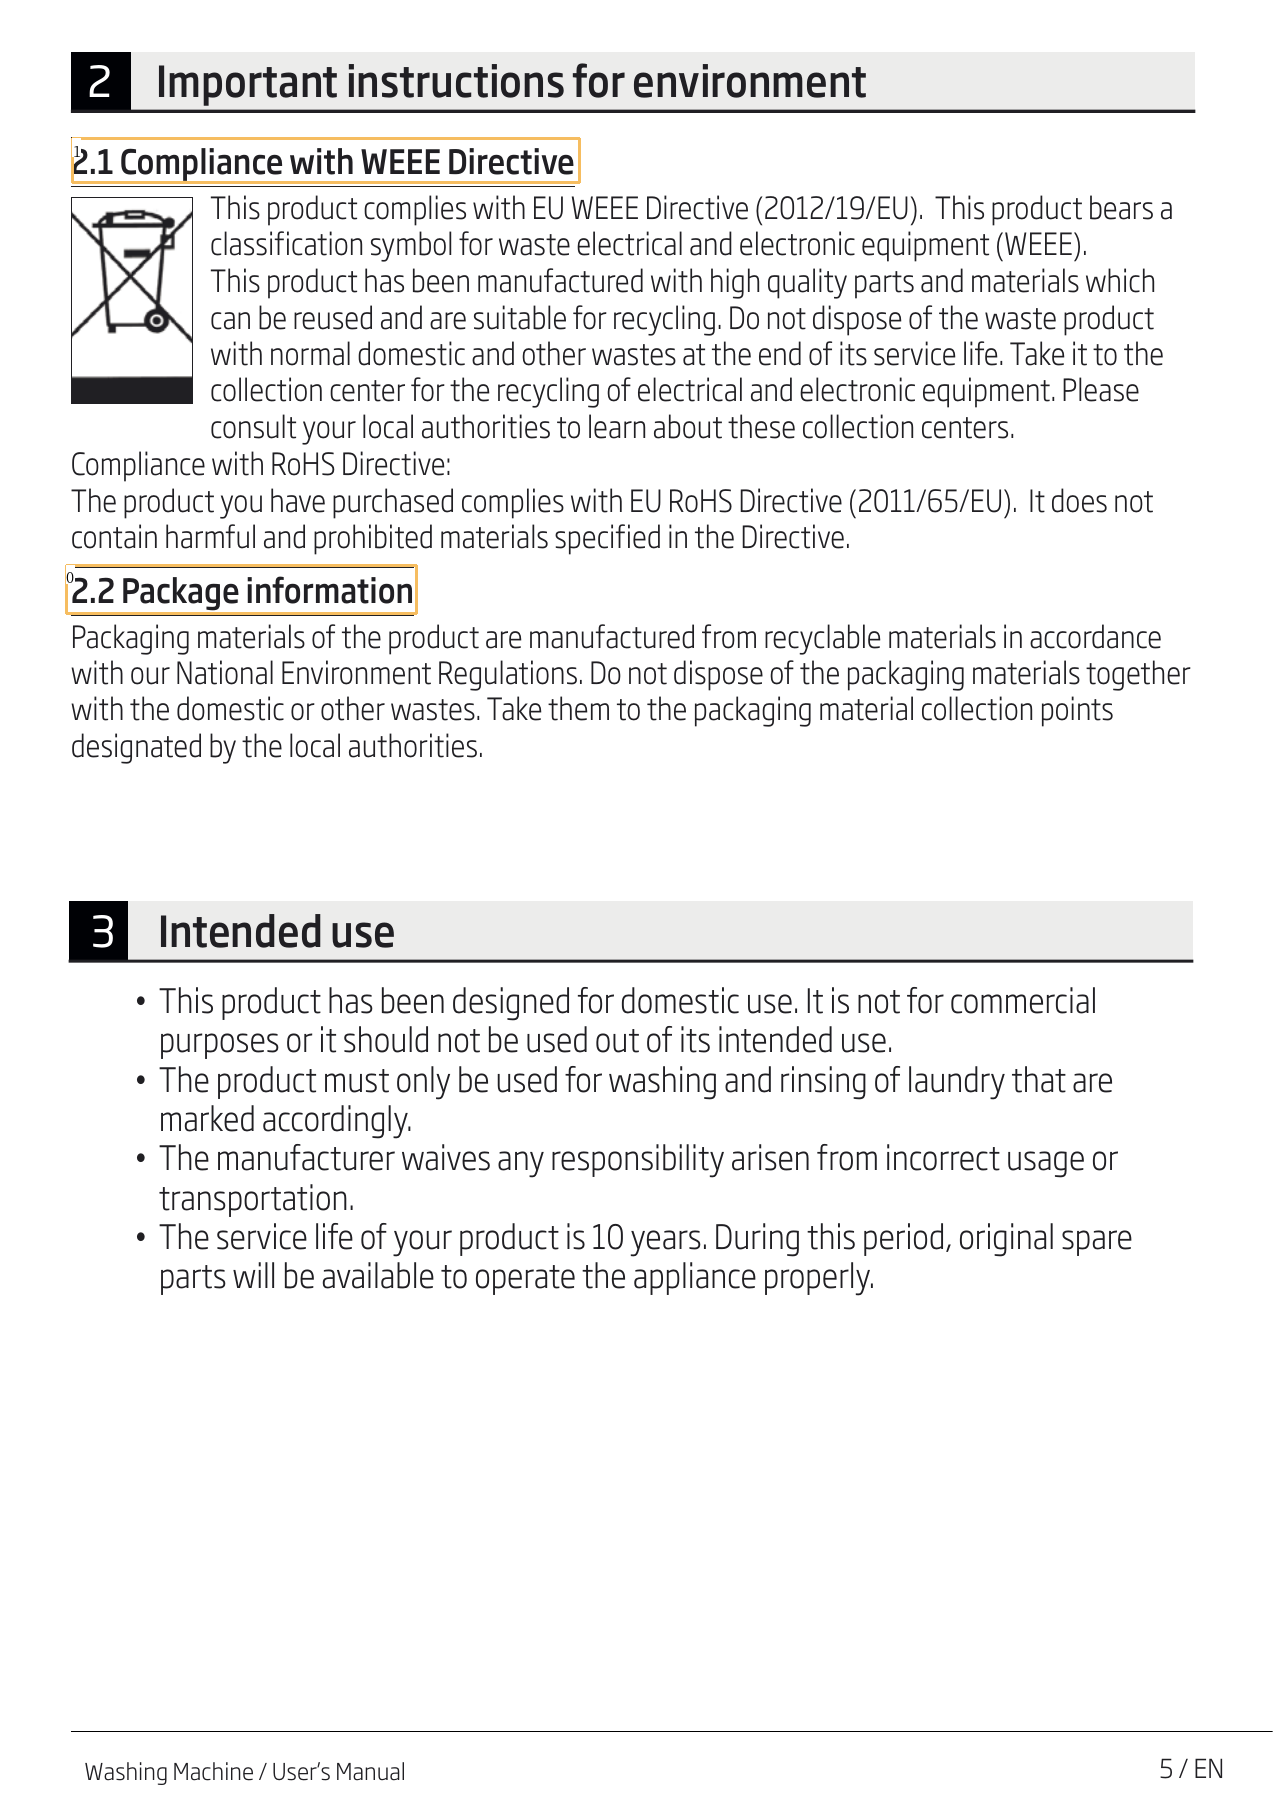

In [ ]:

lp.draw_box(image_cv, text_blocks,
            box_width=3,
            show_element_id=True)

In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng')
    # Initialize the tesseract ocr engine. You might need
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [ ]:
!sudo apt install tesseract-ocr


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image_cv))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

2.2 Package information

---
 

2.1 Compliance with WEEE Directive

 

---


In [ ]:
text_blocks.get_texts()

['2.2 Package information\n\x0c',
 ' \n\n2.1 Compliance with WEEE Directive\n\n \n\x0c']

In [ ]:
for block in text_blocks:
  print(block)

TextBlock(block=Rectangle(x_1=66.15438842773438, y_1=565.149169921875, x_2=416.25152587890625, y_2=613.8631591796875), text=2.2 Package information
, id=0, type=Title, parent=None, next=None, score=0.9465169906616211)
TextBlock(block=Rectangle(x_1=72.63218688964844, y_1=138.83639526367188, x_2=579.7384033203125, y_2=182.8091583251953), text= 

2.1 Compliance with WEEE Directive

 
, id=1, type=Title, parent=None, next=None, score=0.7479046583175659)


In [ ]:
text_blocks = lp.Layout([b for b in layout if b.type=="List"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=110.91757202148438, y_1=183.33604431152344, x_2=1165.0609130859375, y_2=544.6241455078125), text=None, id=None, type=List, parent=None, next=None, score=0.9267236590385437), TextBlock(block=Rectangle(x_1=142.7346954345703, y_1=968.9303588867188, x_2=1137.63671875, y_2=1295.5400390625), text=None, id=None, type=List, parent=None, next=None, score=0.8450306057929993)], page_data={})

In [ ]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [ ]:
h, w = image_cv.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image_cv)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

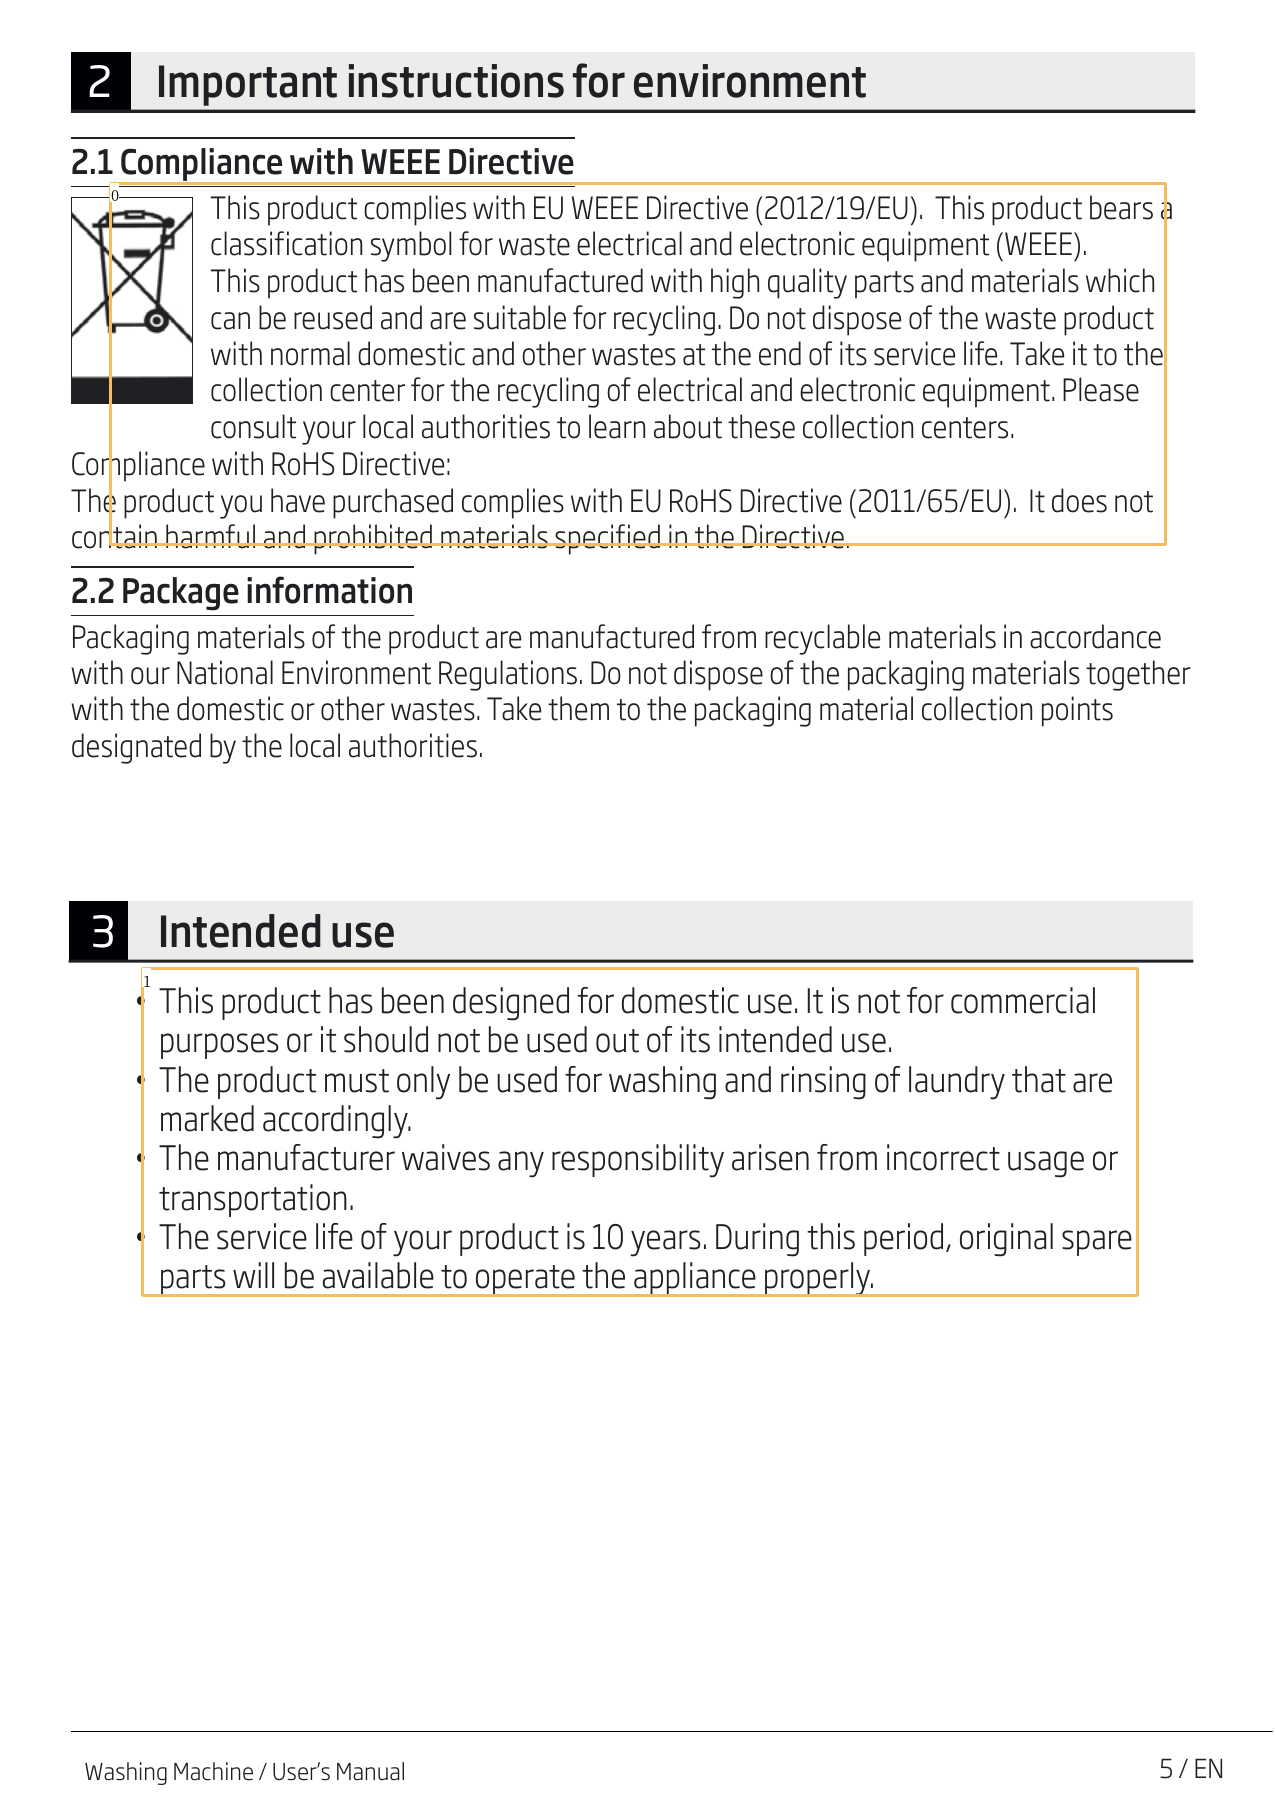

In [ ]:

lp.draw_box(image_cv, text_blocks,
            box_width=3,
            show_element_id=True)

In [ ]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image_cv))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

This product complies with EU WEEE Directive (2012/19/EU). This product bears <
classification symbol for waste electrical and electronic equipment (WEEE).
This product has been manufactured with high quality parts and materials which
can be reused and are suitable for recycling. Do not dispose of the waste product
with normal domestic and other wastes at the end of its service life. Take it to the
collection center for the recycling of electrical and electronic equipment. Please
consult your local authorities to learn about these collection centers.

Npliance with RoHS Directive:

e product you have purchased complies with EU RoHS Directive (2011/65/EU). It does not

tain harmful and prohibited materials specified in the Directive.

---
+ This product has been designed for domestic use. It is not for commercial
purposes or it should not be used out of its intended use.

* The product must only be used for washing and rinsing of laundry that are
marked accordingly.

+ The manufacturer